# Project 1 - Query Project

The project looks at Lyft Bay Wheels (https://www.lyft.com/bikes/bay-wheels), the company running Bay Area Bikeshare. The goal is to try to increase ridership, and to offer deals through the mobile app to do so.
What are the 5 most popular trips that you would call "commuter trips"?
What are your recommendations for offers (justify based on your findings)? 

## Dataset
We are using the San Franscisco Dataset consisting of 3 tables: 
* San Francisco.bikeshare_trips
* San_Francisco.bikeshare_stations 
* San_Fancisco.bikeshare_bikes

An initial look at the data has told us that: 
* There are 983,648 trips in the dataset 
* Lyft Bay Wheels manages 700 bikes
* Lyft Bay Wheels manages 75 stations in the San Francisco region

## Data validation
__Trips__
* There were 296 trips that lasted more than 24 hours. While some of these may have been legitimate trips, others were definitely not. Given the small number of trips in this category relative to the total number of trips in the data set, we remove all these trips from our consideration. 
* No trips lasted less than 60 seconds, which we considered to be a legitimate duration.
* We checked whether there were any trips where the end date was before that start date. There were no such trips.

**Stations**
* There are periods for station 81 during which the numbers of both available bikes and available docks are 0. Since that station did not come into consideration in our analysis, we ignored the problem.

**Bikes**
* The data does not allow for checking for the number of bikes that are out of service at any given time. We will assume that bikes that are available are in working condition and that all bikes that are not available are being used.

In [295]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib

**Total number of trips, bikes and stations**

In [317]:
!bq query --use_legacy_sql=false 'SELECT count(*)as trips FROM `bigquery-public-data.san_francisco.bikeshare_trips`'
! bq query --use_legacy_sql=false 'SELECT count(distinct bike_number) as bikes FROM `bigquery-public-data.san_francisco.bikeshare_trips`'
! bq query --use_legacy_sql=false 'SELECT count(distinct station_id) as stations FROM `bigquery-public-data.san_francisco.bikeshare_status`'

Waiting on bqjob_r675152d7fe7f95e7_00000174e0f94feb_1 ... (0s) Current status: DONE   
+--------+
| trips  |
+--------+
| 983648 |
+--------+
Waiting on bqjob_r3a072a12f44f3211_00000174e0f95846_1 ... (0s) Current status: DONE   
+-------+
| bikes |
+-------+
|   700 |
+-------+
Waiting on bqjob_r3020982efac25f87_00000174e0f96070_1 ... (1s) Current status: DONE   
+----------+
| stations |
+----------+
|       75 |
+----------+


## When is rush hour in San Francisco?  

In [301]:
! bq query --use_legacy_sql=false --format=csv 'select count(distinct trip_id) as num_trips, extract(hour from start_date) as hour_of_day FROM `bigquery-public-data.san_francisco.bikeshare_trips` where extract(dayofweek from start_date) <=5  group by hour_of_day order by num_trips desc' > trips_per_hour.csv

Waiting on bqjob_r477739d258fd6a53_00000174e0ab0799_1 ... (3s) Current status: DONE   


Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


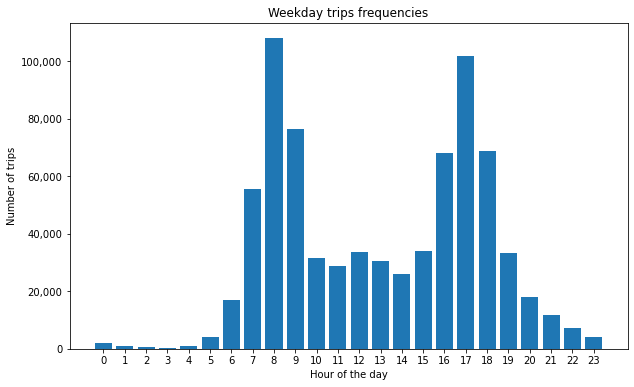

In [302]:
hourly_trips = pd.read_csv("trips_per_hour.csv")
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
fig, ax = plt.subplots()
#width = 0.4
rects1 = ax.bar(hourly_trips.hour_of_day, hourly_trips.num_trips, label='Weekdays') #, color = "blue")
#rects2 = ax.bar(we_hourly_trips.hour_of_day + width/2, we_hourly_trips.num_trips, width, label='Week-ends')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of trips')
ax.set_xlabel('Hour of the day')
ax.set_title('Weekday trips frequencies')
ax.set_xticks(hourly_trips.hour_of_day[::])
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

#plt.bar(hourly_trips.hour_of_day,hourly_trips.num_trips)

Based on the graph above we defined morning rush hour as the period **between 7AM and 10AM,** and we defined afternoon rush hour as the period **after 4pm (16:00) and before 7pm (19:00)**
## Top 5 commuter trips
We extracted the top 10 stations with the largest number of trips during morning rush hour, and the top 10 stations with the largest number of trips during afternoon rush hour.
We then went through the first set (AM trips), and extracted the trips where the ending station is in the second set (PM trips). Of the resulting set we extracted the top 5 with the largest number of trips in the morning. According to our definitions those are the top 5 commuter trips.

**Observations**

It makes sense that the AM starting stations are train stations or ferry terminals or a Bart station (Market at Sansome), as commuters arrive by train or ferry and take a bicycle to get to work in the morning and get back to the train or ferry in the evening to go back home. 
As can be seen, the largest number of AM trips do not necessarily correspond to the largest number of PM trips.
* In 3 cases there are fewer PM trips than there are AM trips. We can surmise that most people are in a rush to get to work in the morning and are more likely to walk back after work. This is backed by the short average bike trip length (about 10 minutes).
* In the two cases where the trip starts at Townsend and 4th in the morning, there are more returns than departure. As we will later on, the reason could be a lack of available bikes in the morning. 
* Finally note that the average trip durations are similar. One can attribute the larger differences (of about 1 minute) to the hilly geography of the city. This is in particular notable in the case of the Ferry Terminal which is at the lowest point by virtue of being on the bay.

In [303]:
! bq query --use_legacy_sql=false --format=csv 'SELECT start_station_name, end_station_name, count(*) as num_trips, round(avg(duration_sec/60),2) as avg_trip_minutes \
FROM `bigquery-public-data.san_francisco.bikeshare_trips` \
where extract(dayofweek from start_date) <= 5 \
and extract(time from start_date) < cast("10:00:00" as time) \
and extract (time from start_date) > cast("07:00:00" as time) \
group by start_station_name, end_station_name \
order by num_trips desc limit 10'> am.csv
! bq query --use_legacy_sql=false --format=csv 'SELECT start_station_name, end_station_name, count(*) as num_trips, round(avg(duration_sec/60),2) as avg_trip_minutes \
FROM `bigquery-public-data.san_francisco.bikeshare_trips` \
where extract(dayofweek from start_date) <= 5 \
and extract(time from start_date) >= cast("16:00:00" as time) \
and extract (time from start_date) < cast("19:00:00" as time) \
group by start_station_name, end_station_name \
order by num_trips desc limit 10'> pm.csv

Waiting on bqjob_r6c8b4790699ce897_00000174e0ab2230_1 ... (0s) Current status: DONE   


**Top 5 commuter trips**

In [318]:
# Find round trips common to AM and PM sets
am_trips = pd.read_csv("am.csv")
pm_trips= pd.read_csv("pm.csv")
am_trips
pm_trips
round_trip = pd.DataFrame(columns = ["AM Start Station","PM Start Station", "#AM trips", "#PM Trips", "Avg AM minutes","Avg PM minutes"])
x=[]
k=0
for i in range(10):
    for j in range(10):
        if (am_trips.start_station_name[i] == pm_trips.end_station_name[j]) and (am_trips.end_station_name[i] == pm_trips.start_station_name[j]):
            round_trip.loc[len(round_trip)] = \
            [am_trips.start_station_name[i], am_trips.end_station_name[i], am_trips.num_trips[i], pm_trips.num_trips[j],\
             am_trips.avg_trip_minutes[i], pm_trips.avg_trip_minutes[j]]

round_trip.to_csv("top_commutes.csv")
round_trip[0:5].style.format({'Avg AM minutes':'{:.2f}','Avg PM minutes':'{:.2f}'} )
      


,AM Start Station,PM Start Station,#AM trips,#PM Trips,Avg AM minutes,Avg PM minutes
0,Harry Bridges Plaza (Ferry Building),2nd at Townsend,3805,3552,9.48,8.23
1,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,2932,2374,4.67,4.43
2,San Francisco Caltrain (Townsend at 4th),Embarcadero at Folsom,2733,3371,10.45,11.04
3,San Francisco Caltrain (Townsend at 4th),Temporary Transbay Terminal (Howard at Beale),2584,2839,11.45,10.94
4,Market at Sansome,2nd at South Park,2397,2671,5.99,6.99


# Non subscribers trips on weekdays and recommendation
We looked at the number of non-subscribers using bikeshare on weekdays. We found that the pattern of the trip frequencies is different for this segment of sharebike users, with a peak between 1pm and 4pm (see graph below). 
While they represent a very small portion of the total number of trips during rush hour, in the daytime off-peak off peak hours (between 10am and 3pm) over 20% of the trips are by non-subscribers.
* Since the total number of trips is relatively low at those times, the company may consider offering a **reduced price subscription for those hours only**
* Furthermore, since the average duration of the trips is around 60 minutes (see box below,) the company may consider offering the **choice of a trip up to 60 minutes** at the appropriate price for non_subscribers

Waiting on bqjob_r86a6d2292b57262_00000174e0c290e1_1 ... (0s) Current status: DONE   
Waiting on bqjob_r15da2aa0a3c27b63_00000174e0c298f5_1 ... (0s) Current status: DONE   
Populating the interactive namespace from numpy and matplotlib


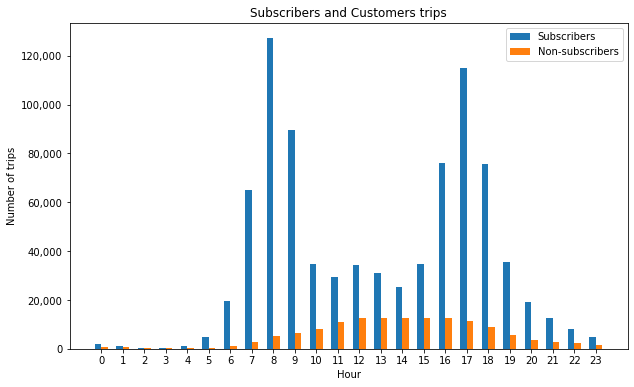

In [314]:
! bq query --use_legacy_sql=false --format=csv 'select count(distinct trip_id) as num_trips, extract(hour from start_date) as hour_of_day FROM `bigquery-public-data.san_francisco.bikeshare_trips` where subscriber_type="Customer" group by hour_of_day order by hour_of_day' > no_sub_per_hour.csv
! bq query --use_legacy_sql=false --format=csv 'select count(distinct trip_id) as num_trips, extract(hour from start_date) as hour_of_day FROM `bigquery-public-data.san_francisco.bikeshare_trips` where subscriber_type="Subscriber" group by hour_of_day order by hour_of_day' > sub_per_hour.csv
nosub_hourly_trips = pd.read_csv("no_sub_per_hour.csv")
sub_hourly_trips = pd.read_csv("sub_per_hour.csv")
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
fig, ax = plt.subplots()
width = 0.3
rects1 = ax.bar(sub_hourly_trips.hour_of_day - width/2, sub_hourly_trips.num_trips, width, label='Subscribers')
rects2 = ax.bar(nosub_hourly_trips.hour_of_day + width/2, nosub_hourly_trips.num_trips, width, label='Non-subscribers')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of trips')
ax.set_xlabel('Hour')
ax.set_title('Subscribers and Customers trips')
ax.set_xticks(hourly_trips.hour_of_day[::])
#ax.set_xticklabels(labels)
ax.legend()
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


**Number and duration of weekday trips by non-subscribers**

In [113]:
! bq query --use_legacy_sql=false 'select count(distinct trip_id) as num_trips, extract(hour from start_date) as hour_of_day, round(avg(duration_sec/60),2) as duration \
FROM `bigquery-public-data.san_francisco.bikeshare_trips` \
where subscriber_type="Customer" \
and extract(dayofweek from start_date) <= 5 \
group by hour_of_day order by num_trips desc limit 12' 

Waiting on bqjob_rc32ad059a0b8cb7_00000174db74a02e_1 ... (1s) Current status: DONE   
+-----------+-------------+----------+
| num_trips | hour_of_day | duration |
+-----------+-------------+----------+
|      8059 |          16 |    47.47 |
|      8025 |          15 |    52.38 |
|      7726 |          13 |    63.98 |
|      7689 |          12 |    61.44 |
|      7686 |          14 |    61.07 |
|      7594 |          17 |    40.43 |
|      6881 |          11 |    71.39 |
|      5899 |          18 |    40.92 |
|      5306 |          10 |    81.98 |
|      4337 |           9 |     63.0 |
|      3863 |           8 |    44.45 |
|      3653 |          19 |    39.05 |
+-----------+-------------+----------+


In [ ]:
! bq query --use_legacy_sql=false --format=csv 'SELECT distinct extract(dayofweek from start_date) as week_day, count(*) as num_trips, avg(duration_sec) as trip_time FROM `bigquery-public-data.san_francisco.bikeshare_trips` where start_station_name = "2nd at Townsend" and end_station_name = "Harry Bridges Plaza (Ferry Building)" and extract(time from start_date) > cast("16:00:00" as time) and extract (time from start_date) < cast("07:00:00" as time) group by week_day order by week_day'> weekday.csv


In [ ]:
! bq query --use_legacy_sql=false --format=csv 'SELECT extract(dayofweek from start_date) as week_day, count(*) as num_trips, avg(duration_sec) as trip_time FROM `bigquery-public-data.san_francisco.bikeshare_trips` where start_station_name = "2nd at Townsend" and end_station_name = "Harry Bridges Plaza (Ferry Building)" and extract(time from start_date) > cast("16:00:00" as time) group by week_day order by week_day'> weekday.csv


# Bike availability during rush hour and recommendation

We goal of this part of the analysis was to determine whether Lyft bikeshare is limiting their client base because potential users cannot find available bikes at their departure stations or lose time finding a docking station for their bikes at their destinations. 

**Analysis**
We extracted the top 12 departure stations during rush hour in terms of number of trips starting there and compared the number of times there were no bikes available at these stations during the same period.  
We also extracted the top 12 destination stations during rush hour in terms of number of trips ending there and compared the number of times there were no docks available at these stations during the same period.
We chose a larger number of destination to be able to identify the top 5 stations that need both more bikes and more docks since in that case the addition of new docks/bikes would be less likely to result in unused bikes or empty docks. However, not surprisingly, the same stations that had not bikes in the morning had no docks in the afternoon and vice versa. So the table below shows the top 12 stations in our analysis.

**Conclusion**
The analysis shows that, for example, while about 43,000 trips started at the **Townsend and 4th** station, there were close to 15,000 instances (more than 30%) of no bike being available. Similarly, with 55,000 trips ending at that station, about 10,000 times there were no docks available (about 20%). 
The **Ferry building (Harry Plaza)** is another case with the number of times there were no bikes available was about 25% of the total number of trips starting there and the cases of no docks available was close to 30% of the total number of trips ending there. 

In these two cases it is very likely that the **demand is there**, and that Lyft Wheels would benefit from adding new bikes/dock stations. We suggest a deeper analysis to determine the **optimal number of docks that should be added to satisfy that demand**. 

**Critique**
Counting the number of times there were no bikes or docks available does not determine the actual number of cases where demand was not satisfied. For that we should have looked at the length of time during which which there was no availability and also determine or obtain the potential number of requests per unit of time. This latter piece of information was not available.  

**Rush hour top starting and top ending stations**

In [270]:
! bq query --use_legacy_sql=false --format=csv 'SELECT start_station_name, start_station_id, count(*) as num_trips \
FROM `bigquery-public-data.san_francisco.bikeshare_trips` \
where extract(dayofweek from start_date) <= 5 \
and (extract(time from start_date) between cast("07:00:00" as time) and cast("10:00:00" as time) \
or extract(time from start_date) between cast("16:00:00" as time) and cast("19:00:00" as time)) \
group by start_station_name, start_station_id \
order by num_trips desc limit 12'> starts.csv
! bq query --use_legacy_sql=false --format=csv 'SELECT end_station_name, end_station_id, count(*) as end_trips \
FROM `bigquery-public-data.san_francisco.bikeshare_trips` \
where extract(dayofweek from start_date) <= 5 \
and (extract(time from start_date) between cast("07:00:00" as time) and cast("10:00:00" as time) \
or extract(time from start_date) between cast("16:00:00" as time) and cast("19:00:00" as time)) \
group by end_station_name, end_station_id \
order by end_trips desc limit 12'> ends.csv

Waiting on bqjob_r2dd35ea3f958273f_00000174e063d7ca_1 ... (0s) Current status: DONE   
Waiting on bqjob_r5a814b2591d73a66_00000174e063dffe_1 ... (1s) Current status: DONE   


**Number of times there were no bikes available and number of times there no docks available during rush hour**

In [266]:
! bq query --use_legacy_sql=false --format=csv 'select station_id, count(time) as zero_bike \
FROM `bigquery-public-data.san_francisco.bikeshare_status` \
where bikes_available = 0 \
and extract(dayofweek from time) <= 5 \
and (extract(time from time) between cast("07:00:00" as time) and cast("10:00:00" as time) \
or extract(time from time) between cast("16:00:00" as time) and cast("19:00:00" as time)) \
group by station_id \
order by zero_bike desc' > nobikes.csv
! bq query --use_legacy_sql=false --format=csv 'select station_id, count(time) as zero_dock \
FROM `bigquery-public-data.san_francisco.bikeshare_status` \
where docks_available = 0 \
and extract(dayofweek from time) <= 5 \
and (extract(time from time) between cast("07:00:00" as time) and cast("10:00:00" as time) \
or extract(time from time) between cast("16:00:00" as time) and cast("19:00:00" as time)) \
group by station_id \
order by zero_dock desc' > nodocks.csv

Waiting on bqjob_r5def018017aa99ff_00000174e05e8cd1_1 ... (0s) Current status: DONE   
Waiting on bqjob_r35c9a19e6e3cd3de_00000174e05e94d3_1 ... (1s) Current status: DONE   


**Results**

In [293]:
## combine the data sets
nobikes = pd.read_csv("nobikes.csv")
trips= pd.read_csv("starts.csv")
nobikes['station_id'] = nobikes['station_id'].astype('int')
trips['start_station_id'] = trips['start_station_id'].astype('int')
trips.set_index('start_station_id')

x=[0]*12
for i in range(12):
    for j in range(len(nobikes.station_id)):
        if (trips.start_station_id[i] == nobikes.station_id[j]):
            x[i]=nobikes.zero_bike[j]
trips["nobikes"] = x
trips["nodocks"] = [0]*12
trips["ended_trips"] = [0]*12
trips.columns=["Station_name","station_id","started_trips","nobikes", "ended_trips","nodocks"]

nodocks = pd.read_csv("nodocks.csv")
trips1 = pd.read_csv("ends.csv")
nodocks['station_id'] = nodocks['station_id'].astype('int')
trips1['end_station_id'] = trips1['end_station_id'].astype('int')

x=[0]*12
for i in range(12):
    for j in range(len(nodocks.station_id)):
        if (trips1.end_station_id[i]  == nodocks.station_id[j]):
            x[i]=nodocks.zero_dock[j]
            
for i in range(12):
    for j in range(len(trips.station_id)):
        if(trips1.end_station_id[i] == trips.station_id[j]):
            trips.nodocks[j] = x[i]
            trips.ended_trips[j] = trips1.end_trips[i]
    if j == len(trips.station_id):
        trips.loc[len(trips.station_id)] = [trips1.end_station_name[i],trips1.end_station_id[i],0,0,trips1.end_trips[i],x[i]]
        
trips.style

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Station_name,station_id,started_trips,nobikes,ended_trips,nodocks
0,San Francisco Caltrain (Townsend at 4th),70,43700,14935,55192,10132
1,San Francisco Caltrain 2 (330 Townsend),69,33961,10028,35855,5587
2,Temporary Transbay Terminal (Howard at Beale),55,24367,11769,20762,1451
3,Harry Bridges Plaza (Ferry Building),50,23463,6276,23012,7319
4,Steuart at Market,74,21460,4947,21720,2093
5,2nd at Townsend,61,20743,3690,22769,744
6,Townsend at 7th,65,17398,10225,20443,3479
7,Embarcadero at Sansome,60,16612,13933,17998,3771
8,Market at Sansome,77,16043,1007,20020,1220
9,Market at 10th,67,14449,9059,11512,50
